### **Step 1:** Get the Data

In [1]:
from fredapi import Fred
import os
from dotenv import load_dotenv

load_dotenv()

fred = Fred(api_key=os.getenv("FRED_API_KEY"))

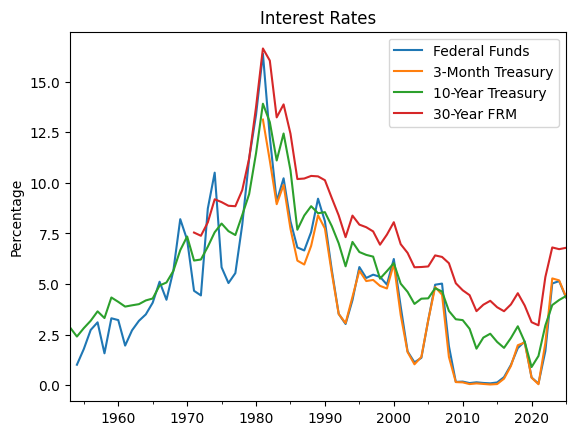

In [2]:
from matplotlib import pyplot as plt

ff = fred.get_series("FEDFUNDS").resample("YS").mean()
rate_3mo = fred.get_series("GS3M").resample("YS").mean()
rate_10y = fred.get_series("GS10").resample("YS").mean()
frm_30y = fred.get_series("MORTGAGE30US").resample("YS").mean()

ff.plot(label="Federal Funds")
rate_3mo.plot(label="3-Month Treasury")
rate_10y.plot(label="10-Year Treasury")
frm_30y.plot(label="30-Year FRM")
plt.title("Interest Rates")
plt.ylabel("Percentage")
plt.legend()

plt.show()

### **Step 2:** Preprocessing

In [3]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    "Federal Funds Rate": ff,
    "3-Month Treasury Rate": rate_3mo,
    "10-Year Treasury Rate": rate_10y,
    "30-Year FRM Rate": frm_30y
})

df = df.interpolate("linear").dropna()
df = df.diff(1).dropna()

df

,Federal Funds Rate,3-Month Treasury Rate,10-Year Treasury Rate,30-Year FRM Rate
1982-01-01,-4.120000,-2.026667,-0.909167,-0.597856
1983-01-01,-3.171667,-2.156667,-1.896667,-2.808269
1984-01-01,1.138333,0.953333,1.333333,0.642308
1985-01-01,-2.124167,-2.166667,-1.815000,-1.447500
1986-01-01,-1.295833,-1.575833,-2.940833,-2.242885
1987-01-01,-0.147500,-0.192500,0.701667,0.026089
1988-01-01,0.910833,0.921667,0.461667,0.128335
1989-01-01,1.648333,1.509167,-0.347500,-0.022308
1990-01-01,-1.117500,-0.650833,0.051667,-0.190000
1991-01-01,-2.411667,-2.204167,-0.691667,-0.882885


### **Step 3:** Analyze FF Rate and Short-Term Rate Relationship

In [4]:
import statsmodels.api as sm
import numpy as np

def ols_summary_and_plot(
    x: pd.Series,
    y: pd.Series
):
    sorted_idxs = x.argsort()

    y_sorted = y.values[sorted_idxs]
    x_sorted = x.values[sorted_idxs]
    X_sorted = sm.add_constant(x_sorted)

    model = sm.OLS(y_sorted, X_sorted)
    results = model.fit()

    print(results.summary())

    preds = results.get_prediction(X_sorted)
    pred_summary = preds.summary_frame(alpha=0.05)

    plt.rcdefaults()
    plt.rcParams.update({
        "font.family": "serif",
        "axes.grid": True,
        "grid.alpha": 0.3
    })

    plt.scatter(
        x, 
        y, 
        s=10, 
        marker="o",
        alpha=0.5
    )
    plt.plot(
        x_sorted, 
        pred_summary["mean"], 
        color="red", 
        label="fit",
        lw=1.0
    )
    plt.fill_between(
        x_sorted,
        pred_summary["mean_ci_lower"],
        pred_summary["mean_ci_upper"],
        color="red",
        alpha=0.3,
        label="95% CI"
    )
    plt.xlabel(f"Δ {x.name}")
    plt.ylabel(f"Δ {y.name}")
    plt.title(f"Δ {y.name} vs. Δ {x.name}")
    plt.legend()
    plt.show()

    def predict(x_new, ci=False, alpha=0.05):
        X_new = sm.add_constant(np.asarray(x_new))
        sf = results.get_prediction(X_new).summary_frame(alpha=alpha)

        return sf[["mean", "mean_ci_lower", "mean_ci_upper"] if ci else "mean"]

    return predict, results

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     651.7
Date:                Sat, 09 Aug 2025   Prob (F-statistic):           3.35e-27
Time:                        14:22:50   Log-Likelihood:                -13.932
No. Observations:                  44   AIC:                             31.86
Df Residuals:                      42   BIC:                             35.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0362      0.052      0.695      0.4

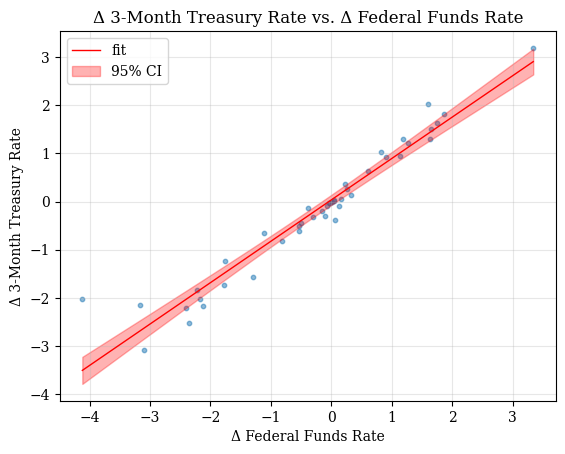

In [5]:
predict_ff_to_3mo, res_ff_to_3mo = ols_summary_and_plot(
    x=df["Federal Funds Rate"],
    y=df["3-Month Treasury Rate"]
)

### **Step 4:** Analyze Short and Long Term Rate Relationship

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     38.75
Date:                Sat, 09 Aug 2025   Prob (F-statistic):           1.89e-07
Time:                        14:22:50   Log-Likelihood:                -42.224
No. Observations:                  44   AIC:                             88.45
Df Residuals:                      42   BIC:                             92.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1265      0.099     -1.284      0.2

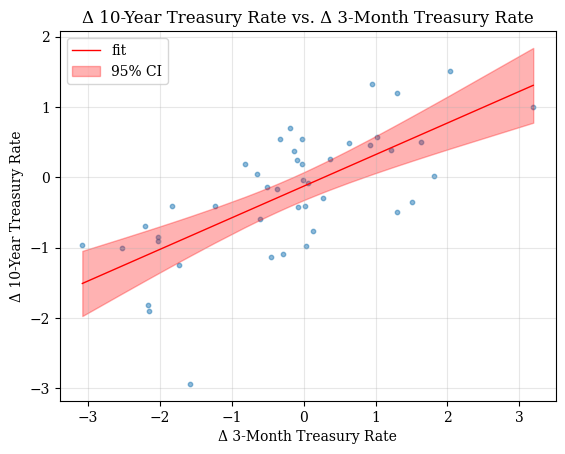

In [6]:
predict_3mo_to_10y, res_3mo_to_10y = ols_summary_and_plot(
    x=df["3-Month Treasury Rate"],
    y=df["10-Year Treasury Rate"]
)

### **Step 5:** Analyze Long Term and FRM Relationship

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     201.0
Date:                Sat, 09 Aug 2025   Prob (F-statistic):           1.32e-17
Time:                        14:22:50   Log-Likelihood:                -17.101
No. Observations:                  44   AIC:                             38.20
Df Residuals:                      42   BIC:                             41.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0314      0.057     -0.553      0.5

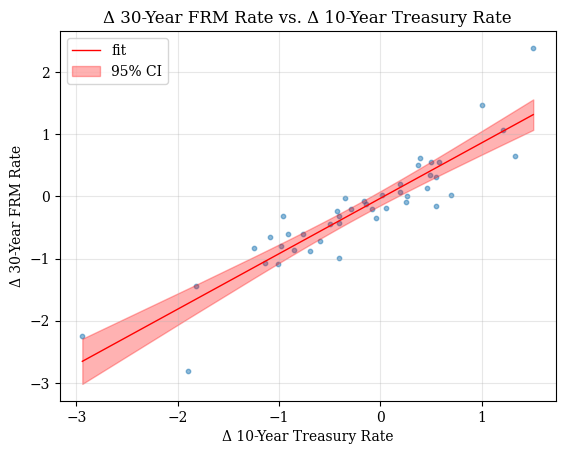

In [7]:
predict_10y_to_30y, res_10y_to_30y = ols_summary_and_plot(
    x=df["10-Year Treasury Rate"],
    y=df["30-Year FRM Rate"]
)

### **Step 3:** Analyze Composite Effect of FF on 30-Year FRMs

In [9]:
import numpy as np

def make_drawer(results):
    """Return a function that draws (const, beta) from the OLS sampling dist."""
    mu = results.params
    cov = results.cov_params()
    def drawer(n_draws):
        draws = np.random.multivariate_normal(mu, cov, size=n_draws)
        c = draws[:, 0][:, None]
        b = draws[:, 1][:, None]
        return c, b
    return drawer

def chain_bootstrap(ff, res1, res2, res3, n_draws=2000, alpha=0.05):
    """Parametric bootstrap CIs for the chained linear maps."""
    x = np.asarray(ff)[None, :]
    d1, d2, d3 = map(make_drawer, (res1, res2, res3))
    c1, b1 = d1(n_draws); x1 = c1 + b1 * x
    c2, b2 = d2(n_draws); x2 = c2 + b2 * x1
    c3, b3 = d3(n_draws); y  = c3 + b3 * x2
    mean = y.mean(axis=0)
    lo   = np.quantile(y, alpha/2, axis=0)
    hi   = np.quantile(y, 1 - alpha/2, axis=0)

    return pd.DataFrame({
        "mean": mean,
        "lo": lo,
        "hi": hi
    }, index=ff.index)

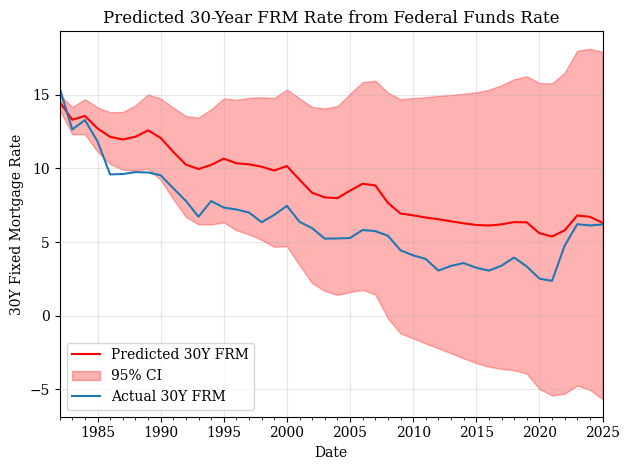

In [10]:
start = df.index[0]

frm_30y_hat = chain_bootstrap(
    df["Federal Funds Rate"],
    res_ff_to_3mo, res_3mo_to_10y, res_10y_to_30y,
    n_draws=2000, alpha=0.05
).cumsum() + frm_30y[start]

frm_30y_actual = df["30-Year FRM Rate"].cumsum() + frm_30y[start]

plt.rcdefaults()
plt.rcParams.update({
    "font.family": "serif",
    "axes.grid": True,
    "grid.alpha": 0.3
})
frm_30y_hat["mean"].plot(
    color="red", 
    label="Predicted 30Y FRM"
)
plt.fill_between(
    frm_30y_hat.index, 
    frm_30y_hat["lo"], 
    frm_30y_hat["hi"], 
    color="red", 
    alpha=0.3, 
    label="95% CI"
)
frm_30y_actual.plot(label="Actual 30Y FRM")

plt.xlabel("Date")
plt.ylabel("30Y Fixed Mortgage Rate")
plt.title("Predicted 30-Year FRM Rate from Federal Funds Rate")
plt.legend()
plt.tight_layout()
plt.show()